# Melt, Weather --> LSTM --> streamflow

# Preamble

In [1]:
#first: are you working in colab?
colab = 1

if colab:
    
    #mount drive
    from google.colab import drive
    drive.mount('/content/drive')
    
    dataPath = '/content/drive/My Drive/Colab Notebooks/T_P_F_pca_lstm/'
    
else:
    
    dataPath = ''


Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
#import required libraries

import pandas as pd
import numpy as np
#from netCDF4 import Dataset
from keras.layers import Dense, LSTM, Flatten, Dropout
from keras.models import Sequential, load_model
from keras.callbacks import EarlyStopping
from keras import regularizers
import keras
import pickle
import matplotlib.pyplot as plt

In [0]:
#define NSE

def nse(y_obs, y_model):

  """
  NSE = nse(y_obs, y_model)

  y_obs, y_model --> these are arrays of the same length (1 x N or N x1) where N is the number of observations in time
  """

  y_model = y_model.reshape((-1,1))
  y_obs = y_obs.reshape((-1,1))
  nse = 1 - np.sum((y_model - y_obs)**2) / np.sum((y_obs - np.mean(y_obs))**2)
  return nse

def nse_rolling(y_obs, y_model, window, stride = 1):

  """
  NSE_rolling = nse_rolling(y_obs, y_model, window, stride)

  y_obs, y_model --> these are arrays of the same length (1 x N or N x 1) where N is the number of observations in time
  window --> this is the length of time over which to compute NSE, which will roll accross the total time period
  stride --> default stride = 1; length of step to take when rolling (i.e. stride = 365 computes yearly NSE with no overlap)
  """

  NSE_rolling = []

  y_model = y_model.reshape((-1,1))
  y_obs = y_obs.reshape((-1,1))

  startInds = range(0, len(y_model) - window, stride)
  for startInd in startInds:
    y_model_window = y_model[startInd:startInd+window] 
    y_obs_window = y_obs[startInd:startInd+window]
    NSE = nse(y_obs_window, y_model_window)
    NSE_rolling.append(NSE)

  return NSE_rolling


In [44]:
a = range(0,10,2)
print([item for item in a])

[0, 2, 4, 6, 8]


# Load data and pre-process

In [0]:
#M = pd.read_csv(dataPath + 'stationGlacierMelt.csv',header=None)
M = pd.read_csv(dataPath + 'stationGlacierRunoff.csv',header=None)

pickle_in = open(dataPath + 'flowDict.pickle','rb')
flowDict = pickle.load(pickle_in)

pickle_in = open(dataPath + 'tempDict.pickle','rb')
tempDict = pickle.load(pickle_in)

pickle_in = open(dataPath + 'precDict.pickle','rb')
precDict = pickle.load(pickle_in)

pickle_in = open(dataPath + 'relHDict.pickle','rb')
relHDict = pickle.load(pickle_in)

pickle_in = open(dataPath + 'ssrdDict.pickle','rb')
ssrdDict = pickle.load(pickle_in)

#unpack data

stationLat = flowDict['stationLat']
stationLon = flowDict['stationLon']
eraLat = tempDict['latERA']
eraLon = tempDict['lonERA']

flowDays = flowDict['windowDays']
flowMonths = flowDict['windowMonths']
flowYears = flowDict['windowYears']
eraDays = tempDict['daysERA']
eraMonths = tempDict['monthsERA']
eraYears = tempDict['yearsERA']

F = flowDict['all_flowwindow_norm_NF'] #normalized discharge with nans filled (NF)
T = tempDict['T']
P = precDict['P']
H = relHDict['H']
S = ssrdDict['S']

In [0]:
#make data have same time range
startYear = max(int(np.min(eraYears)),int(np.min(flowYears)))

indStartERA = min(np.argwhere(eraYears==startYear))[0]
indStartFlow = min(np.argwhere(flowYears==startYear))[0]

F = np.asarray(np.transpose(np.squeeze(F[indStartFlow:])))
T = np.asarray(T[indStartERA:])
P = np.asarray(P[indStartERA:])
H = np.asarray(H[indStartERA:])
S = np.asarray(S[indStartERA:])
M = np.asarray(M.iloc[:,indStartERA:])

##just alberta
#T = T[:,:15,29:]
#P = P[:,:15,29:]
#H = H[:,:15,28:]
#S = S[:,:15,28:]

flowDays = flowDays[indStartFlow:]
flowMonths = flowMonths[indStartFlow:]
flowYears = flowYears[indStartFlow:]

eraDays = eraDays[indStartERA:]
eraMonths = eraMonths[indStartERA:]
eraYears = eraYears[indStartERA:]

In [0]:
#loop through stations and find the closest era grid cell

stationT = np.empty((len(stationLat),len(eraDays)))
stationP = np.empty((len(stationLat),len(eraDays)))
stationH = np.empty((len(stationLat),len(eraDays)))
stationS = np.empty((len(stationLat),len(eraDays)))
stationM = np.empty((len(stationLat),len(eraDays)))

for kk in range(len(stationLat)): #for each station
    
    dlat = np.min(np.abs(stationLat[kk] - eraLat))
    indLat = np.argwhere(np.abs(stationLat[kk] - eraLat) == dlat)[0]
    dlon = np.min(np.abs(stationLon[kk] - eraLon))
    indLon = np.argwhere(np.abs(stationLon[kk] - eraLon) == dlon)[0]
    
    stationT[kk] = np.squeeze(T[:,indLat,indLon])
    stationP[kk] = np.squeeze(P[:,indLat,indLon])
    stationH[kk] = np.squeeze(H[:,indLat,indLon])
    stationS[kk] = np.squeeze(S[:,indLat,indLon])
    stationM[kk] = np.squeeze(M[kk])
    
#use only stations with glaciers
stationsWithGlaciers = np.squeeze(np.argwhere(np.sum(stationM,axis=1)>0))
stationT = stationT[stationsWithGlaciers,:]
stationP = stationP[stationsWithGlaciers,:]
stationH = stationH[stationsWithGlaciers,:]
stationS = stationS[stationsWithGlaciers,:]
stationM = stationM[stationsWithGlaciers,:]
F = F[:,stationsWithGlaciers]

#normalize
stationT = (stationT - np.mean(stationT))/np.std(stationT)
stationP = (stationP - np.mean(stationP))/np.std(stationP)
stationH = (stationH - np.mean(stationH))/np.std(stationH)
stationS = (stationS - np.mean(stationS))/np.std(stationS)
stationM = (stationM - np.mean(stationM))/np.std(stationM)


In [0]:
#normalize flow to be between 0 and 1

for station in range(np.shape(F)[1]):
    #F[:,station] = (F[:,station] - np.mean(F[:,station]))/np.std(F[:,station])
    minF = np.min(F[:,station])
    maxF = 2 * np.std(F[:,station])
    F[:,station] = (F[:,station] - minF) / (maxF - minF)
    
    for inds in np.argwhere(F>4):
      F[inds[0],inds[1]] = 4
  

# Build model on multiple stations

In [0]:
#create input/output datasets

num_stations = len(stationsWithGlaciers)

num_obs = (len(eraDays) - 365) * num_stations #len(stationsWithGlaciers)

x = np.empty((num_obs,365,5))
y = np.empty((num_obs))

jj = 0

for station in range(num_stations): #range(len(stationsWithGlaciers)): #for each station
    
    for day in range(len(eraDays)-365): #for each day of flow
        
        x[jj,:,0] = stationT[station,day:day+365]
        x[jj,:,1] = stationP[station,day:day+365]
        x[jj,:,2] = stationH[station,day:day+365]
        x[jj,:,3] = stationS[station,day:day+365]
        x[jj,:,4] = stationM[station,day:day+365]
        y[jj] = F[day+365,station]
        jj+=1
    

In [0]:
#split into train/validate/test

#trainSplit = 'fraction' #define fraction of data to have as train/valid/test
trainSplit = 'LOSO' #leave one (or more) station(s) out for validation, one (or more) for testing
#trainSplit = 'LOYO' #leave one (or more) year(s) out for validation, one (or more) for testing

if trainSplit == 'fraction': 

  fracTrain = 0.8
  fracValid = 0.1
  Ntrain = int(fracTrain * len(x))
  Nvalid = int(fracValid * len(x))
  Ntest = len(x) - Ntrain - Nvalid

  x_train = x[:Ntrain]
  y_train = y[:Ntrain]

  x_test = x[Ntrain:]
  y_test = y[Ntrain:]

elif trainSplit == 'LOSO':

  num_stations_valid = 2
  num_stations_test = 2
  num_stations_train = num_stations - num_stations_valid - num_stations_test

  Ntrain = (len(eraDays) - 365) * (num_stations_train)  
  Nvalid = (len(eraDays) - 365) * (num_stations_valid)
  Ntest = (len(eraDays) - 365) * (num_stations_test)

  x_train = x[:Ntrain]
  y_train = y[:Ntrain]

  x_valid = x[Ntrain : Ntrain + Nvalid]
  y_valid = y[Ntrain : Ntrain + Nvalid]

  x_test = x[Ntrain + Nvalid :]
  y_test = y[Ntrain + Nvalid :]

elif trainSplit == 'LOYO':

  obs_per_station = int(len(x) / num_stations)
  Ntest_per_station = 730
  Ntrain_per_station = int(obs_per_station - Ntest_per_station)

  x_train = np.empty((Ntrain_per_station * num_stations,365,5))
  y_train = np.empty((Ntrain_per_station * num_stations))

  x_test = np.empty((Ntest_per_station * num_stations,365,5))
  y_test = np.empty((Ntest_per_station * num_stations))

  kk = 0
  jj = 0
  ii = 0
  for station in range(num_stations):

    x_train_station = x[kk : kk+Ntrain_per_station]
    y_train_station = y[kk : kk+Ntrain_per_station]

    x_test_station = x[kk+Ntrain_per_station : kk+obs_per_station]
    y_test_station = y[kk+Ntrain_per_station : kk+obs_per_station]

    x_train[jj : jj+Ntrain_per_station] = x_train_station
    y_train[jj : jj+Ntrain_per_station] = y_train_station

    x_test[ii : ii+Ntest_per_station] = x_test_station
    y_test[ii : ii+Ntest_per_station] = y_test_station

    kk += obs_per_station
    jj += Ntrain_per_station
    ii += Ntest_per_station


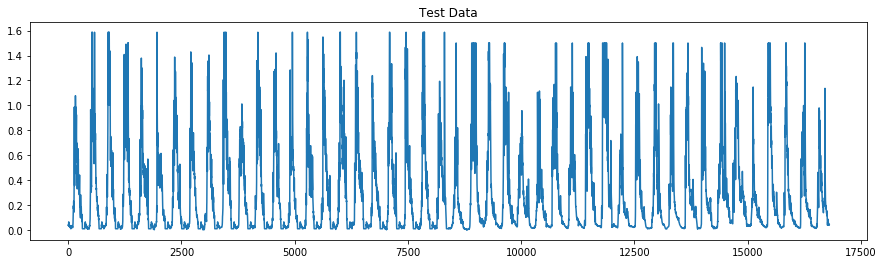

In [98]:
#visualize test dataset

plt.figure(figsize=(15,4))
plt.plot(y_test)
plt.title('Test Data')
plt.show()

In [99]:
#build model

model = Sequential()
model.add(LSTM(20, 
               input_shape = (365,5), 
               return_sequences = True,
               #return_state = True,
               kernel_regularizer = regularizers.l2(0.001)))
model.add(Dropout(rate = 0.1))
model.add(LSTM(20, 
               input_shape = (365,5), 
               return_sequences = True,
               #return_state = True,
               kernel_regularizer = regularizers.l2(0.001)))
model.add(Flatten())
model.add(Dense(1,
                activation = 'linear'))
model.compile(loss = 'mse', 
              optimizer=keras.optimizers.Adam(lr=0.005))
model.summary()

es = EarlyStopping(monitor='val_loss', 
                   mode='min', 
                   verbose=1, 
                   patience = 5)

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_5 (LSTM)                (None, 365, 20)           2080      
_________________________________________________________________
dropout_3 (Dropout)          (None, 365, 20)           0         
_________________________________________________________________
lstm_6 (LSTM)                (None, 365, 20)           3280      
_________________________________________________________________
flatten_3 (Flatten)          (None, 7300)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 7301      
Total params: 12,661
Trainable params: 12,661
Non-trainable params: 0
_________________________________________________________________


In [103]:
#train model

batch_size = 2048
epochs = 10
history = model.fit(x_train,y_train, 
                    validation_split = 0.2,
                    shuffle = True, 
                    epochs = epochs, 
                    batch_size = batch_size,
                    verbose = 1, 
                    callbacks = [es])

Train on 94091 samples, validate on 23523 samples
Epoch 1/10
94091/94091 [==============================] - 51s 538us/step - loss: 0.0258 - val_loss: 0.0248
Epoch 2/10
94091/94091 [==============================] - 51s 542us/step - loss: 0.0248 - val_loss: 0.0236
Epoch 3/10
94091/94091 [==============================] - 51s 537us/step - loss: 0.0237 - val_loss: 0.0238
Epoch 4/10
94091/94091 [==============================] - 50s 537us/step - loss: 0.0229 - val_loss: 0.0231
Epoch 5/10
94091/94091 [==============================] - 50s 535us/step - loss: 0.0218 - val_loss: 0.0214
Epoch 6/10
94091/94091 [==============================] - 51s 538us/step - loss: 0.0206 - val_loss: 0.0221
Epoch 7/10
94091/94091 [==============================] - 51s 540us/step - loss: 0.0232 - val_loss: 0.0257
Epoch 8/10
94091/94091 [==============================] - 51s 541us/step - loss: 0.0215 - val_loss: 0.0227
Epoch 9/10
94091/94091 [==============================] - 51s 537us/step - loss: 0.0197 - val_

In [0]:
#save model

modelName = str(num_stations) + '_stations_' + 'LSTM_DO_LSTM_DENSE'
model.save(modelName + '.h5')

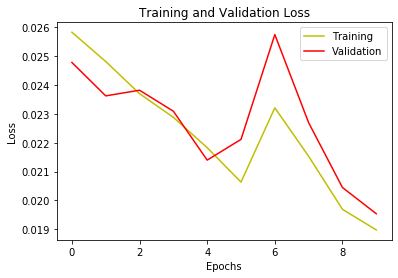

In [105]:
saveIt = 0

loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)

plt.plot(loss, 'y', label='Training')
plt.plot(val_loss, 'r', label='Validation')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
#plt.xlim((1,10))
#plt.ylim((0,.1))
#plt.show()

if saveIt:
  plt.savefig('loss.png')

In [0]:
#predict streamflow with trained model

y_testPredict = model.predict(x_test)


In [107]:
#compute NSE

window = 90
NSE = nse(y_test,y_testPredict)
NSE_rolling = nse_rolling(y_test, y_testPredict, window, stride = 1)

print('NSE = ' + str(NSE)[:4])

NSE = 0.69


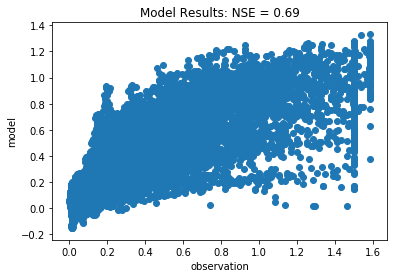

In [108]:
#visualize

saveIt = 0

plt.scatter(y_test,y_testPredict)
plt.xlabel('observation')
plt.ylabel('model')
plt.title('Model Results: NSE = ' + str(NSE)[:4])

if saveIt:
  plt.savefig('obs_vs_model.png')

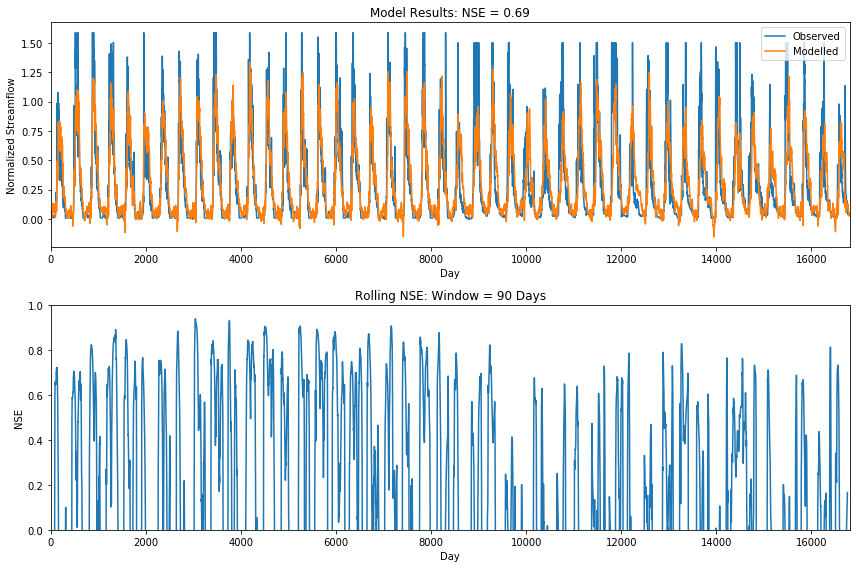

In [109]:
#visualize time series 

saveIt = 0

plt.figure(figsize = (12,8))
plt.subplot(2,1,1)
plt.plot(y_test, label = 'Observed')
plt.plot(y_testPredict, label = 'Modelled')
#plt.xlim((4500,6000))
plt.legend()
plt.xlabel('Day')
plt.ylabel('Normalized Streamflow')
plt.title('Model Results: NSE = ' + str(NSE)[:4])
plt.xlim((0,len(y_test)))

plt.subplot(2,1,2)
plt.plot(range(int(window/2),len(y_test)-int(window/2)),NSE_rolling)
plt.ylim((0,1))
plt.xlim((0,len(y_test)))
plt.xlabel('Day')
plt.ylabel('NSE')
plt.title('Rolling NSE: Window = ' + str(window) + ' Days')

plt.tight_layout()

if saveIt:
  plt.savefig('modelled_time_series.png')

plt.show()

# Investigate performance in space and time

In [0]:
#what are the streamflow predictions at all stations?

load_saved_predictions = 0

if load_saved_predictions:
  pickle_in = open(dataPath + 'y_predict.pickle','rb')
  y_predict = pickle.load(pickle_in)
elif not load_saved_predictions:
  #y_predict = model.predict(x)
  y_predict = model.predict(x)

save_predictions = 1

if save_predictions:
  pickle_out = open('y_predict_' + str(num_stations) + '_stations.pickle','wb')
  pickle.dump(y_predict,pickle_out)
  pickle_out.close()

In [0]:
#what are the streamflow predictions at each station?

obs_per_station = int(len(x)/num_stations)
NSE_station = []
NSE_rolling_station = []

kk = 0
for station in range(num_stations):
  
  NSE = nse(y[kk : kk+obs_per_station], y_predict[kk : kk+obs_per_station])
  NSE_station.append(NSE)

  NSE_rolling = nse_rolling(y[kk : kk+obs_per_station], y_predict[kk : kk+obs_per_station], window = 366, stride = 365)
  NSE_rolling_station.append(NSE_rolling)

  kk += obs_per_station


In [0]:
def plot_AB(prov='AB'):

    """
    plot borders of alberta
    
    example:
    import geopandas as gpd
    import matplotlib.pyplot as plt
    plot_AB()
    plt.show()
    """
    
    provIndex=0
    provshapes_filename = '/content/drive/My Drive/Colab Notebooks/cnn_lstm_era/PROVINCE.SHP'
    provshapes = gpd.read_file(provshapes_filename)
    provPoly = provshapes['geometry'][provIndex]
    lonBorder,latBorder = provPoly.exterior.coords.xy 

    plt.plot(lonBorder,latBorder,'k')

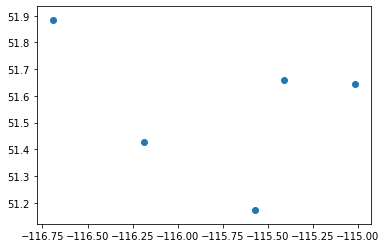

In [93]:
inds = stationsWithGlaciers[range(num_stations)]
plt.scatter(stationLon[inds], stationLat[inds])

# Fine tuning on one station

In [0]:
#create input/output datasets

station_fine_tune = 2

num_obs = (len(eraDays) - 365) #len(stationsWithGlaciers)

x = np.empty((num_obs,365,5))
y = np.empty((num_obs))

jj = 0
   
for day in range(len(eraDays)-365): #for each day of flow
    
    x[jj,:,0] = stationT[station_fine_tune,day:day+365]
    x[jj,:,1] = stationP[station_fine_tune,day:day+365]
    x[jj,:,2] = stationH[station_fine_tune,day:day+365]
    x[jj,:,3] = stationS[station_fine_tune,day:day+365]
    x[jj,:,4] = stationM[station_fine_tune,day:day+365]
    y[jj] = F[day+365,station_fine_tune]
    jj+=1

In [0]:
#split into train/test
fracTrain = 0.8
Ntrain = int(fracTrain * len(x))

x_train = x[:Ntrain]
y_train = y[:Ntrain]

x_test = x[Ntrain:]
y_test = y[Ntrain:]

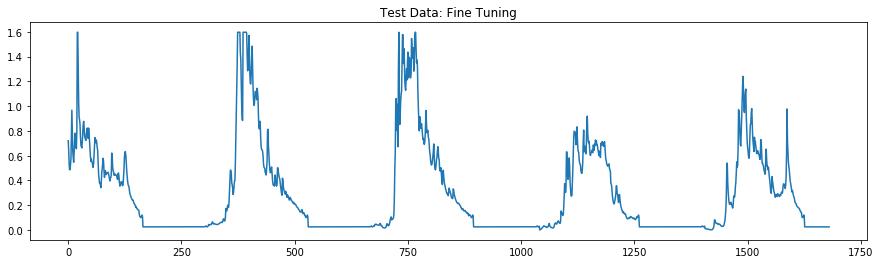

In [25]:
#visualize test data

plt.figure(figsize=(15,4))
plt.plot(y_test)
plt.title('Test Data: Fine Tuning')
plt.show()

In [0]:
#load model

model = load_model('5_stations_LSTM_DO_LSTM_DENSE.h5')

In [26]:
#train model

batch_size = 128
epochs = 10
history = model.fit(x_train,y_train, 
                    validation_split = 0.2, 
                    epochs = epochs, 
                    batch_size = batch_size,
                    verbose = 1, 
                    callbacks = [es])

Train on 5376 samples, validate on 1344 samples
Epoch 1/10
5376/5376 [==============================] - 42s 8ms/step - loss: 0.0224 - val_loss: 0.0275
Epoch 2/10
5376/5376 [==============================] - 42s 8ms/step - loss: 0.0181 - val_loss: 0.0213
Epoch 3/10
5376/5376 [==============================] - 42s 8ms/step - loss: 0.0167 - val_loss: 0.0196
Epoch 4/10
5376/5376 [==============================] - 42s 8ms/step - loss: 0.0154 - val_loss: 0.0224
Epoch 5/10
5376/5376 [==============================] - 42s 8ms/step - loss: 0.0148 - val_loss: 0.0209
Epoch 6/10
5376/5376 [==============================] - 42s 8ms/step - loss: 0.0138 - val_loss: 0.0224
Epoch 7/10
5376/5376 [==============================] - 42s 8ms/step - loss: 0.0137 - val_loss: 0.0236
Epoch 8/10
5376/5376 [==============================] - 42s 8ms/step - loss: 0.0125 - val_loss: 0.0199
Epoch 00008: early stopping


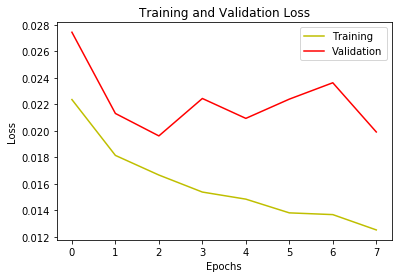

In [27]:
saveIt = 0

loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)

plt.plot(loss, 'y', label='Training')
plt.plot(val_loss, 'r', label='Validation')
plt.title('Training and Validation Loss')

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
#plt.ylim((0,1))
#plt.show()

if saveIt:
  plt.savefig('loss.png')

In [0]:
#predict streamflow with trained model
#y_trainPredict = model.predict(x_train)
y_testPredict = model.predict(x_test)

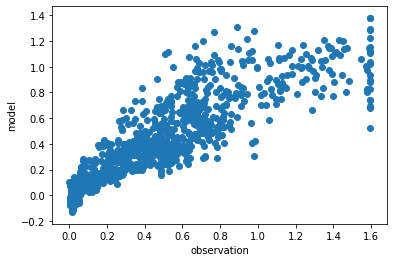

In [29]:
#visualize

saveIt = 0

plt.scatter(y_test,y_testPredict)
plt.xlabel('observation')
plt.ylabel('model')

if saveIt:
  plt.savefig('obs_vs_model.png')

In [63]:
#compute NSE

window = 366
stride = 365
NSE = nse(y_test,y_testPredict)
NSE_rolling = nse_rolling(y_test, y_testPredict, window = window, stride = stride)
print('NSE = ' + str(NSE)[:4])

NSE = 0.82


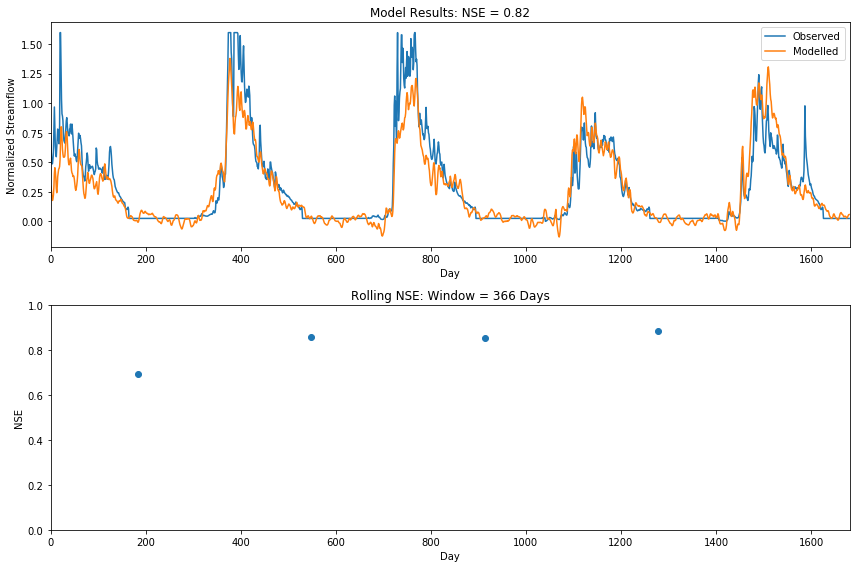

In [65]:
#visualize more

saveIt = 0

plt.figure(figsize = (12,8))

plt.subplot(2,1,1)
plt.plot(y_test, label = 'Observed')
plt.plot(y_testPredict, label = 'Modelled')
#plt.xlim((4500,6000))
plt.legend()
plt.xlabel('Day')
plt.ylabel('Normalized Streamflow')
plt.xlim((0,len(y_test)))
plt.title('Model Results: NSE = ' + str(NSE)[:4])

plt.subplot(2,1,2)
plt.scatter(range(int(window/2),len(y_test)-int(window/2), stride),NSE_rolling)
#plt.plot(NSE_rolling)
plt.ylim((0,1))
plt.xlim((0,len(y_test)))
plt.xlabel('Day')
plt.ylabel('NSE')
plt.title('Rolling NSE: Window = ' + str(window) + ' Days')

plt.tight_layout()

if saveIt:
  plt.savefig('modelled_time_series.png')

plt.show()

In [62]:
range(int(window/2),len(y_test)-int(window/2), stride)

NameError: ignored

# What is the model learning?

In [0]:
#investigate what the model is looking at in test set

day = 100 #day number in test set to visualize what model is 'thinking' when predicting flow at this day
iters = 1
fracOnes = 0.9 #fraction to leave unmaksed
nones = int(365*fracOnes)
nzeros = 365 - nones
heat = np.zeros((1,365,5))

xday = np.reshape(x_test[day],(1,365,5))
yday = model.predict(xday)

for iter in range(iters):
  
  #mask = np.hstack((np.ones(nones), np.zeros(nzeros)))
  #np.random.shuffle(mask)
  #mask = np.reshape(mask,(1,365,1))
  #xday_mask = xday*mask
  #yday_mask = model.predict(xday_mask)

  #delta = np.abs(yday - yday_mask)
  #heat += delta * (1 - mask)

  noise = (np.random.rand(1,365,5) - 0.5)/5
  xday_noise = xday + noise
  yday_noise = model.predict(xday_noise)
  
  delta = np.abs(yday - yday_noise)#**2
  heat += delta * np.abs(noise)

  #del noise
  #del xday_noise


  



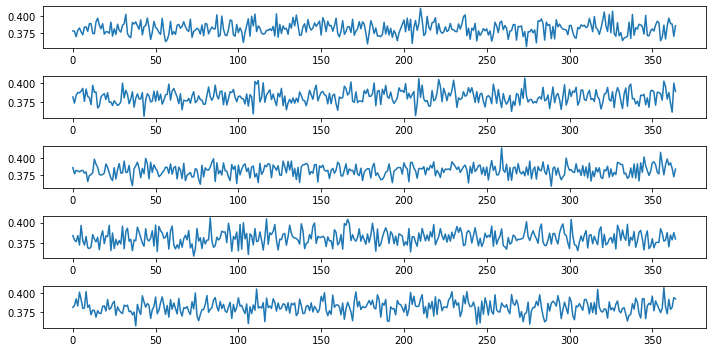

In [0]:
#visualize heatmap

plt.figure(figsize = (10,5))

for var in range(5):
  plt.subplot(5,1,var+1)
  plt.plot(np.squeeze(heat[0,:,var]))

#plt.subplot(111)
#plt.plot(np.squeeze(heat))
#plt.xlabel('Days before flow')
#plt.ylabel('Relative importance')
plt.tight_layout()
plt.show()

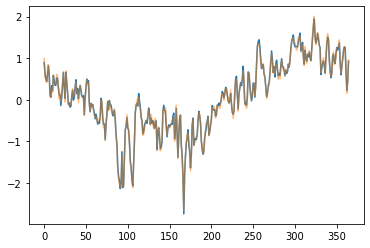

In [0]:
plt.plot(xday[0,:,0])
plt.plot(xday_noise[0,:,0],alpha = 0.5)

In [0]:
import keras.backend as K
statesAll=[]
for layer in model.layers:
  print(layer)
  if getattr(layer,'stateful',False):
    if hasattr(layer,'states'):
      print('hi')
      for state in layer.states:
        statesAll.append(K.get_value(state))

In [0]:
model.layers

In [0]:
np.shape(xday[0,:,0])

(365,)

In [0]:
n = 10
m = 10
a = np.hstack((np.ones(n), np.zeros(m)))
print(np.random.shuffle(a))

None


In [0]:
a = xday*mask

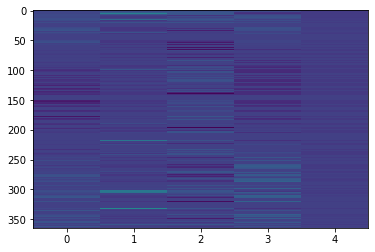

In [0]:
plt.imshow(np.squeeze(a),aspect='auto')

(0, 100)

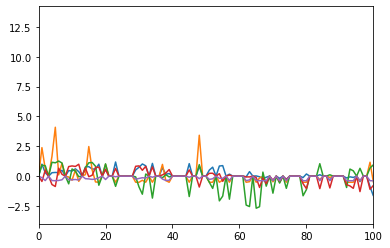

In [0]:
plt.plot(np.sum(a,axis=0))
plt.xlim((0,100))

In [0]:
from keras import backend as K
K.tensorflow_backend._get_available_gpus()

['/job:localhost/replica:0/task:0/device:GPU:0']

In [0]:
import scipy
#def create_mask(h = 1, w = 10, H = 5, W = 365, p_1 = 0.7):

h = 2
w = 10
H = 5
W = 365
p_1 = 0.7

mask_small = np.random.choice([0,1], size = (h,w), p = [1-p_1, p_1])
x1 = [val for val in range(w)]
y1 = [val for val in range(h)]
x2 = [val * (w/W) for val in range(W)]
y2 = [val * (h/H) for val in range(H)]
f = scipy.interpolate.interp2d(x1,y1,mask_small,kind = 'linear')
mask_large = f(x2,y2,mask_small)

#return mask_small, mask_large

#mask_small, mask = create_mask()
plt.imshow(mask_large)


ValueError: ignored

In [0]:
mask_large

In [0]:
# create a random mask
def create_mask(h=7, w=7, H=224, W=224, p_1=0.5, resample=Image.BILINEAR):

    # create random hxw mask
    mask = np.random.choice([0, 1], size=(h, w), p=[1 - p_1, p_1])

    # resize
    mask = Image.fromarray(mask * 255.)
    mask = mask.resize((H + h, W + w), resample=resample)
    mask = np.array(mask)

    # crop to HxW
    w_crop = np.random.randint(0, w + 1)
    h_crop = np.random.randint(0, h + 1)
    mask = mask[h_crop:H + h_crop, w_crop:W + w_crop]

    # normalize
    mask /= np.max(mask)

    return mask

In [0]:
window = 90
NSE_rolling = nse_rolling(y_test, y_testPredict, window=window)

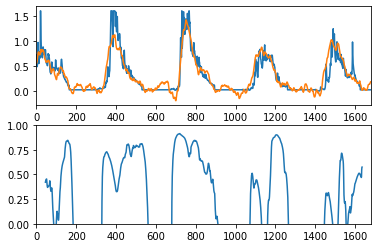

In [115]:
plt.subplot(2,1,1)
plt.plot(y_test)
plt.plot(y_testPredict)
plt.xlim((0,len(y_test)))

plt.subplot(2,1,2)
plt.plot(range(int(window/2),len(y_test)-int(window/2)),NSE_rolling)
plt.ylim((0,1))
plt.xlim((0,len(y_test)))

plt.show()

In [113]:
len(NSE_rolling)

1591

In [114]:
len(y_test)

1681